In [1]:
!pip install -q sqlite3

ERROR: Could not find a version that satisfies the requirement sqlite3 (from versions: none)
ERROR: No matching distribution found for sqlite3

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import sqlite3
connection = sqlite3.connect(database="e-com.sqlite", check_same_thread=False)

In [2]:
import requests
response = requests.get("http://127.0.0.1:8000/products/all").json()

In [3]:
response

{'lazada': [1040858590, 2730432618, 2792189799],
 'shopee': [5873954476,
  24509035804,
  27253416536,
  27312277956,
  27603632331,
  29560903606],
 'tiki': [26140236,
  57422387,
  197665885,
  248280562,
  271362153,
  271973414,
  273258825,
  273880674,
  274037360,
  274057334,
  275078722,
  275127044,
  275716541,
  276425741]}

In [23]:
for p in response:
    if p == "lazada":
        for i in response[p]:
            pdp = requests.get(f"http://127.0.0.1:8000/product/{p}/{i}").json()
            review = requests.get(f"http://127.0.0.1:8000/product-reviews/{p}/{i}").json()
            print(i)
    elif p == "shopee":
        for i in response[p]:
            pdp = requests.get(f"http://127.0.0.1:8000/product/{p}/{i}").json()
            review = requests.get(f"http://127.0.0.1:8000/product-reviews/{p}/{i}").json()
            pass
    elif p =="tiki":
        for i in response[p]:
            pdp = requests.get(f"http://127.0.0.1:8000/product/{p}/{i}").json()
            review = requests.get(f"http://127.0.0.1:8000/product-reviews/{p}/{i}").json()
            print(i)

1040858590
2730432618
2792189799
26140236
57422387
197665885
248280562
271362153
271973414
273258825
273880674
274037360
274057334
275078722
275127044
275716541
276425741


In [26]:
import pandas as pd
import requests
from typing import Dict, List, Any

def process_platform_data(response: Dict[str, List[str]]) -> pd.DataFrame:
    """
    Process product data from multiple e-commerce platforms and return a standardized DataFrame.
    
    Args:
        response: Dictionary with platform names as keys and lists of product IDs as values
    
    Returns:
        pd.DataFrame: Standardized DataFrame containing product information
    """
    all_products = []
    
    for platform in response:
        for product_id in response[platform]:
            # Fetch product and review data
            base_url = "http://127.0.0.1:8000"
            pdp = requests.get(f"{base_url}/product/{platform}/{product_id}").json()
            review = requests.get(f"{base_url}/product-reviews/{platform}/{product_id}").json()
            
            # Process based on platform
            if platform == "shopee":
                product_data = {
                    "url": pdp.get("url"),
                    "product_id": pdp.get("item_id"),
                    "title": pdp.get("title"),
                    "image": pdp.get("image"),
                    "brand": pdp.get("brand"),
                    "rating": pdp.get("item_rating", {}).get("rating_star"),
                    "location": pdp.get("shop_location"),
                    "description": pdp.get("description"),
                    "stock": pdp.get("stock"),
                    "platform": "shopee"
                }
            
            elif platform == "lazada":
                product_data = {
                    "url": pdp.get("url"),
                    "product_id": pdp.get("itemId"),
                    "title": pdp.get("title"),
                    "image": pdp.get("mainImageUrl"),
                    "brand": pdp.get("skus", [{}])[0].get("specifications", {}).get("Brand"),
                    "rating": pdp.get("ratingAverage"),
                    "location": None,
                    "description": pdp.get("description"),
                    "stock": pdp.get("skus", [{}])[0].get("stock"),
                    "platform": "lazada"
                }
            
            elif platform == "tiki":
                product_data = {
                    "url": pdp.get("short_url"),
                    "product_id": pdp.get("id"),
                    "title": pdp.get("name"),
                    "image": pdp.get("images", [{}])[0].get("base_url"),
                    "brand": next((attr.get("value") for spec in pdp.get("specifications", [])
                                for attr in spec.get("attributes", [])
                                if attr.get("code") == "brand"), None),
                    "rating": pdp.get("rating_average"),
                    "location": None,
                    "description": pdp.get("description"),
                    "stock": pdp.get("stock_item", {}).get("qty"),
                    "platform": "tiki"
                }
            
            all_products.append(product_data)
    
    # Create DataFrame with standardized columns
    df = pd.DataFrame(all_products)
    
    # Ensure consistent data types
    df["rating"] = pd.to_numeric(df["rating"], errors="coerce")
    df["stock"] = pd.to_numeric(df["stock"], errors="coerce")
    
    return df

if __name__ == "__main__":
    sample_response = requests.get("http://127.0.0.1:8000/products/all").json()
    df = process_platform_data(sample_response)
    print(df.head())

                                                 url   product_id  \
0  https://www.lazada.vn/products/macbook-air-202...   1040858590   
1  https://www.lazada.vn/products/sale-lon-15-171...   2730432618   
2  https://www.lazada.vn/products/iphone-16-pro-m...   2792189799   
3  https://shopee.vn/M%C3%A1y-t%C3%ADnh-x%C3%A1ch...   5873954476   
4  https://shopee.vn/B%E1%BB%99-PC-M%C3%A1y-T%C3%...  24509035804   

                                               title  \
0   MacBook Air 2020 13.3 inches M1- Hàng Chính Hãng   
1  [SALE LỚN 15-17.11] Smart Tivi Samsung 4K Crys...   
2           iPhone 16 Pro Max - Hàng Chính Hãng VN/A   
3  Máy tính xách tay Apple MacBook Air (2020) M1 ...   
4  Bộ PC Máy Tính Robot Gaming CGO i5/i7, Ram 8/1...   

                                               image         brand  rating  \
0  https://laz-img-sg.alicdn.com/p/cb6d6d6ca52787...         Apple  4.8000   
1  https://vn-test-11.slatic.net/p/a34e40768de687...       Samsung  5.0000   
2  https://vn-

In [39]:
df.to_sql(name='pdp', con=connection, if_exists='replace', index=False)

23

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   url          23 non-null     object 
 1   product_id   23 non-null     int64  
 2   title        23 non-null     object 
 3   image        23 non-null     object 
 4   brand        23 non-null     object 
 5   rating       23 non-null     float64
 6   location     6 non-null      object 
 7   description  23 non-null     object 
 8   stock        17 non-null     float64
 9   platform     23 non-null     object 
dtypes: float64(2), int64(1), object(7)
memory usage: 1.9+ KB


In [32]:
!pip install -q ipython-sql


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [35]:
%load_ext autoreload
%load_ext sql
%autoreload 2
%sql sqlite:////e-com.sqlite

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [37]:
import sqlite3

# Connect to the database
conn = sqlite3.connect('e-com.sqlite')
cursor = conn.cursor()

# Execute the query to list all tables
cursor.execute("SELECT name FROM sqlite_master WHERE type='table'")

# Fetch and print results
tables = cursor.fetchall()
for table in tables:
    print(table[0])

# Close the connection
conn.close()

In [63]:
import pandas as pd
import requests
import json
from typing import Dict, List, Any

def process_platform_data(response: Dict[str, List[str]]) -> pd.DataFrame:
    all_reviews = []
    
    for platform in response:
        for product_id in response[platform]:
            # Fetch product and review data
            base_url = "http://127.0.0.1:8000"
            review = requests.get(f"{base_url}/product-reviews/{platform}/{product_id}").json()
            
            # Process based on platform
            if platform == "shopee":
                product_review = {
                    "product_id": product_id,
                    "platform": platform,
                    "total_reviews": review.get("review", {}).get("data", {}).get("item_rating_summary", {}).get("rating_total"),
                    "reviews": json.dumps(review.get("review", {}).get("data", {}).get("ratings", []))
                }
            
            elif platform == "lazada":
                product_review = {
                    "product_id": product_id,
                    "platform": platform,
                    "total_reviews": review.get("review", {}).get("total_reviews"),
                    "reviews": json.dumps(review.get("review").get("reviews", {}))
                }
            
            elif platform == "tiki":
                product_review = {
                    "product_id": product_id,
                    "platform": platform,
                    "total_reviews": review.get("review").get("reviews_count"),
                    "reviews": json.dumps(review.get("review").get("data"))
                }
            
            all_reviews.append(product_review)
    
    # Create DataFrame with standardized columns
    df = pd.DataFrame(all_reviews)
    
    # Ensure consistent data types
    # df["total_reviews"] = pd.to_numeric(df["total_reviews"], errors="coerce")
    
    return df

if __name__ == "__main__":
    sample_response = requests.get("http://127.0.0.1:8000/products/all").json()
    df = process_platform_data(sample_response)
    print(df.head(2))

   product_id platform  total_reviews  \
0  1040858590   lazada             65   
1  2730432618   lazada             65   

                                             reviews  
0  [{"reviewRateId": 424016786958590, "itemId": 1...  
1  [{"reviewRateId": 434310094932618, "itemId": 2...  


In [64]:
df

,product_id,platform,total_reviews,reviews
0,1040858590,lazada,65,"[{""reviewRateId"": 424016786958590, ""itemId"": 1..."
1,2730432618,lazada,65,"[{""reviewRateId"": 434310094932618, ""itemId"": 2..."
2,2792189799,lazada,65,"[{""reviewRateId"": 431928081889799, ""itemId"": 2..."
3,5873954476,shopee,2626,"[{""orderid"": 0, ""itemid"": 5873954476, ""cmtid"":..."
4,24509035804,shopee,71,"[{""orderid"": 0, ""itemid"": 24509035804, ""cmtid""..."
5,27253416536,shopee,103,"[{""orderid"": 0, ""itemid"": 27253416536, ""cmtid""..."
6,27312277956,shopee,13,"[{""orderid"": 0, ""itemid"": 27312277956, ""cmtid""..."
7,27603632331,shopee,0,[]
8,29560903606,shopee,1094,"[{""orderid"": 0, ""itemid"": 29560903606, ""cmtid""..."
9,26140236,tiki,0,[]


In [65]:
df.to_sql(name='review', con=connection, if_exists='replace', index=False)

23

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     23 non-null     int64 
 1   platform       23 non-null     object
 2   total_reviews  23 non-null     int64 
 3   reviews        23 non-null     object
dtypes: int64(2), object(2)
memory usage: 868.0+ bytes


In [73]:
import os
from datetime import date
from glob import glob

today = date.today().isoformat()  # Lấy ngày hôm nay dạng YYYY-MM-DD

today_files = []

for platform in ['tiki', 'shopee', 'lazada']:
    platform_dir = os.path.join("D:\\FIA1471\\data", platform)
    if os.path.exists(platform_dir):
        today_files.extend(glob(os.path.join(platform_dir, f"*{today}.json")))
[i for i in today_files]

['D:\\FIA1471\\data\\tiki\\197665885_2024-12-10.json',
 'D:\\FIA1471\\data\\tiki\\248280562_2024-12-10.json',
 'D:\\FIA1471\\data\\tiki\\26140236_2024-12-10.json',
 'D:\\FIA1471\\data\\tiki\\271362153_2024-12-10.json',
 'D:\\FIA1471\\data\\tiki\\271973414_2024-12-10.json',
 'D:\\FIA1471\\data\\tiki\\273258825_2024-12-10.json',
 'D:\\FIA1471\\data\\tiki\\273880674_2024-12-10.json',
 'D:\\FIA1471\\data\\tiki\\274037360_2024-12-10.json',
 'D:\\FIA1471\\data\\tiki\\274057334_2024-12-10.json',
 'D:\\FIA1471\\data\\tiki\\275078722_2024-12-10.json',
 'D:\\FIA1471\\data\\tiki\\275127044_2024-12-10.json',
 'D:\\FIA1471\\data\\tiki\\275716541_2024-12-10.json',
 'D:\\FIA1471\\data\\tiki\\276425741_2024-12-10.json',
 'D:\\FIA1471\\data\\tiki\\57422387_2024-12-10.json',
 'D:\\FIA1471\\data\\shopee\\24509035804_2024-12-10.json',
 'D:\\FIA1471\\data\\shopee\\27253416536_2024-12-10.json',
 'D:\\FIA1471\\data\\shopee\\27312277956_2024-12-10.json',
 'D:\\FIA1471\\data\\shopee\\27603632331_2024-12-10.jso

In [77]:
pd.Timestamp.now() + pd.DateOffset(-10)

Timestamp('2024-11-30 14:24:48.605896')

In [82]:
pd.date_range((pd.Timestamp.now() - pd.DateOffset(10)).isoformat(), pd.Timestamp.now().isoformat())\
    .strftime('%Y-%m-%d')

Index(['2024-11-30', '2024-12-01', '2024-12-02', '2024-12-03', '2024-12-04',
       '2024-12-05', '2024-12-06', '2024-12-07', '2024-12-08', '2024-12-09',
       '2024-12-10'],
      dtype='object')

In [ ]:
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi
import json
from pathlib import Path
from config import *

uri = URI
client = MongoClient(uri, server_api=ServerApi('1'))
db = client['datashop']
collection = db[...]

data_dir = Path(r'D:\FIA1471\data\tiki')

for json_file in data_dir.glob('*.json'):
    if json_file.is_file():
        with open(json_file, 'r', encoding='utf-8') as f:
            data = json.load(f)
            collection.insert_one(data)
            print(f'Inserted data from {json_file.name} into MongoDB.')
    else:
        print(f'Tệp {json_file.name} không tồn tại hoặc không phải là tệp thông thường.')

In [131]:
from pathlib import Path
data_dir = Path(r'D:\FIA1471\data\shopee')

for json_file in data_dir.glob('*2024-12-10.json'):
    with open(json_file, 'r', encoding='utf-8') as f:
        data = json.load(f)
        collection.insert_one(data)
        print(f'Inserted data from {json_file.name} into MongoDB.')

Inserted data from 24509035804_2024-12-10.json into MongoDB.
Inserted data from 27253416536_2024-12-10.json into MongoDB.
Inserted data from 27312277956_2024-12-10.json into MongoDB.
Inserted data from 27603632331_2024-12-10.json into MongoDB.
Inserted data from 29560903606_2024-12-10.json into MongoDB.
Inserted data from 5873954476_2024-12-10.json into MongoDB.


In [2]:
#!pip install "dbt-core>=1.4.0,<1.6.0" "dbt-sqlite>=1.4.0,<1.6.0"

In [ ]:
import pandas as pd
import requests
import json
from typing import Dict, List, Any

def process_platform_data(response: Dict[str, List[str]]) -> pd.DataFrame:
    historicals = []
    
    for platform in response:
        for product_id in response[platform]:
            # Fetch product and review data
            base_url = "http://127.0.0.1:8000"
            historical = requests.get(f"{base_url}/price-history/{platform}/{product_id}").json()
            # Process based on platform
            if platform == "shopee":
                hist = pd.DataFrame(historical['price_history'])
                hist["platform"] = "shopee"
                hist["itemId"] = product_id
            elif platform == "lazada":
                pass
            elif platform == "tiki":
                pass
            
            all_reviews.append(product_review)
    
    # Create DataFrame with standardized columns
    df = pd.DataFrame(historicals)
    
    return df

if __name__ == "__main__":
    sample_response = requests.get("http://127.0.0.1:8000/products/all").json()
    df = process_platform_data(sample_response)
    print(df.head(2))

In [6]:
import pandas as pd
import requests
import json
from typing import Dict, List, Any

def process_tiki_price_history(product_id: int) -> pd.DataFrame:
    base_url = "http://127.0.0.1:8000"
    
    # Fetch price history for the specific product
    response = requests.get(f"{base_url}/price-history/tiki/{product_id}")
    
    # Check if request was successful
    if response.status_code != 200:
        raise ValueError(f"Failed to fetch data for product {product_id}")
    
    # Parse the JSON response
    data = response.json()
    
    # Convert price history to DataFrame
    df = pd.DataFrame(data['price_history'])
    
    # Optionally, convert scraped_timestamp to datetime
    df['scraped_timestamp'] = pd.to_datetime(df['scraped_timestamp'])
    df['platform'] = "tiki"
    return df

def main():
    product_id = 26140236  # From the provided JSON
    try:
        price_history_df = process_tiki_price_history(product_id)
        
        # Display basic information
        print("Price History DataFrame:")
        print(price_history_df)
        
        # Additional analysis if needed
        print("\nPrice Statistics:")
        print(f"Number of records: {len(price_history_df)}")
        print(f"Date range: {price_history_df['scraped_timestamp'].min()} to {price_history_df['scraped_timestamp'].max()}")
        print(f"Unique prices: {price_history_df['salePrice'].unique()}")
        
    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    main()

Price History DataFrame:
                                                title  salePrice  stock_qty  \
0   Bộ PC XGAME8184 i3 8100/8G/GTX 1050Ti 4Gb - Hà...   12000000       1000   
1   Bộ PC XGAME8184 i3 8100/8G/GTX 1050Ti 4Gb - Hà...   12000000       1000   
2   Bộ PC XGAME8184 i3 8100/8G/GTX 1050Ti 4Gb - Hà...   12000000       1000   
3   Bộ PC XGAME8184 i3 8100/8G/GTX 1050Ti 4Gb - Hà...   12000000       1000   
4   Bộ PC XGAME8184 i3 8100/8G/GTX 1050Ti 4Gb - Hà...   12000000       1000   
5   Bộ PC XGAME8184 i3 8100/8G/GTX 1050Ti 4Gb - Hà...   12000000       1000   
6   Bộ PC XGAME8184 i3 8100/8G/GTX 1050Ti 4Gb - Hà...   12000000       1000   
7   Bộ PC XGAME8184 i3 8100/8G/GTX 1050Ti 4Gb - Hà...   12000000       1000   
8   Bộ PC XGAME8184 i3 8100/8G/GTX 1050Ti 4Gb - Hà...   12000000       1000   
9   Bộ PC XGAME8184 i3 8100/8G/GTX 1050Ti 4Gb - Hà...   12000000       1000   
10  Bộ PC XGAME8184 i3 8100/8G/GTX 1050Ti 4Gb - Hà...   12000000       1000   
11  Bộ PC XGAME8184 i3 8100

In [33]:
import pandas as pd
import requests
from typing import Dict, List

def process_platform_data(response: Dict[str, List[str]]) -> pd.DataFrame:
    historicals = []
    
    for platform in response:
        for product_id in response[platform]:
            # Fetch product and review data
            base_url = "http://127.0.0.1:8000"
            historical = requests.get(f"{base_url}/price-history/{platform}/{product_id}").json()

            if platform == "shopee":
                hist = pd.DataFrame(historical['price_history'])
                hist['scraped_timestamp'] = pd.to_datetime(hist['scraped_timestamp'])
                hist["platform"] = "shopee"
                hist["itemId"] = product_id
                historicals.append(hist)
            elif platform == "lazada":
                hist = pd.DataFrame(historical['price_history'])
                hist['scraped_timestamp'] = pd.to_datetime(hist['scraped_timestamp'])
                hist["platform"] = "lazada"
                hist["itemId"] = product_id
                historicals.append(hist)
            elif platform == "tiki":
                hist = pd.DataFrame(historical['price_history'])
                hist['scraped_timestamp'] = pd.to_datetime(hist['scraped_timestamp'])
                hist["platform"] = "tiki"
                hist["itemId"] = product_id
                historicals.append(hist)
    
    if historicals:
        df = pd.concat(historicals, ignore_index=True)
    else:
        df = pd.DataFrame()
    return df.drop(columns=["skuId", "stock_qty"])

if __name__ == "__main__":
    sample_response = requests.get("http://127.0.0.1:8000/products/all").json()
    df = process_platform_data(sample_response)
    assert df.columns.to_list() == ['title', 'salePrice', 'itemId', 'scraped_timestamp', 'platform']
    df

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   title              545 non-null    object        
 1   salePrice          545 non-null    float64       
 2   itemId             545 non-null    int64         
 3   scraped_timestamp  545 non-null    datetime64[ns]
 4   platform           545 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 21.4+ KB


In [35]:
# import sqlite3
# connection = sqlite3.connect(database="e-com.sqlite", check_same_thread=False)
# df.to_sql(name='historical', con=connection, if_exists='replace', index=False)

In [37]:
!pip install -q seaborn


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


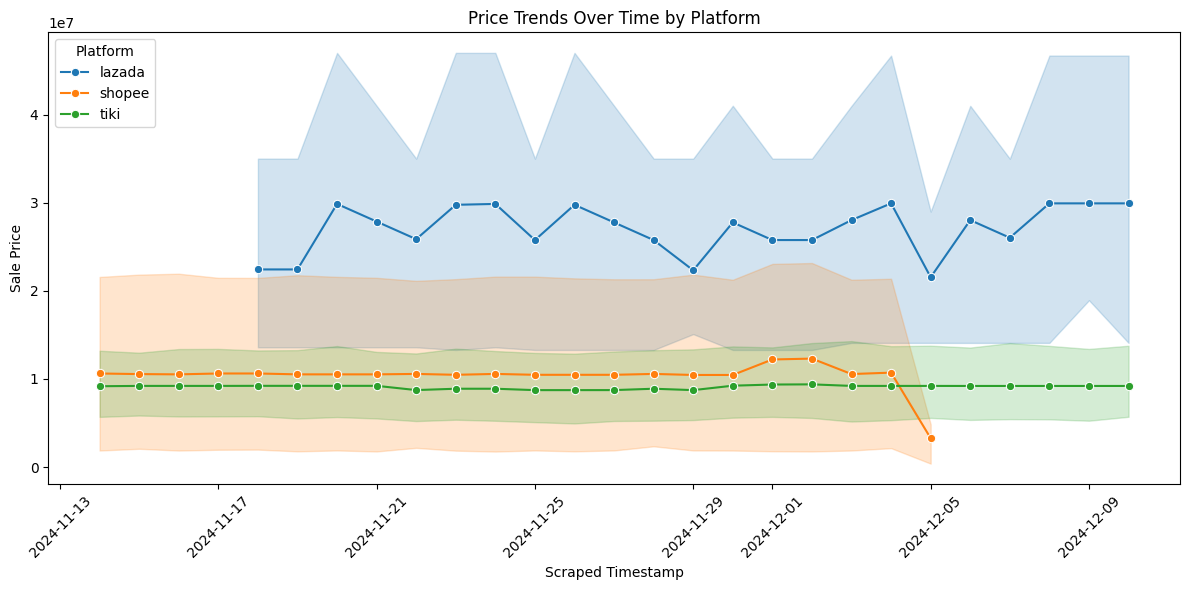

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Price trends over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='scraped_timestamp', y='salePrice', hue='platform', marker='o')
plt.title('Price Trends Over Time by Platform')
plt.xlabel('Scraped Timestamp')
plt.ylabel('Sale Price')
plt.xticks(rotation=45)
plt.legend(title='Platform')
plt.tight_layout()
plt.show()

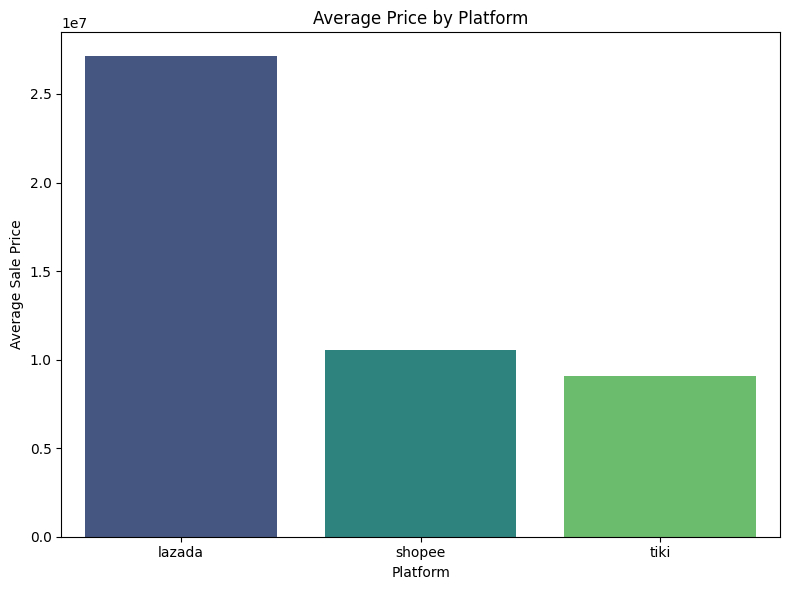

In [40]:
# Average price by platform
avg_price_by_platform = df.groupby('platform')['salePrice'].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(data=avg_price_by_platform, x='platform', y='salePrice', palette='viridis', hue='platform')
plt.title('Average Price by Platform')
plt.xlabel('Platform')
plt.ylabel('Average Sale Price')
plt.tight_layout()
plt.show()

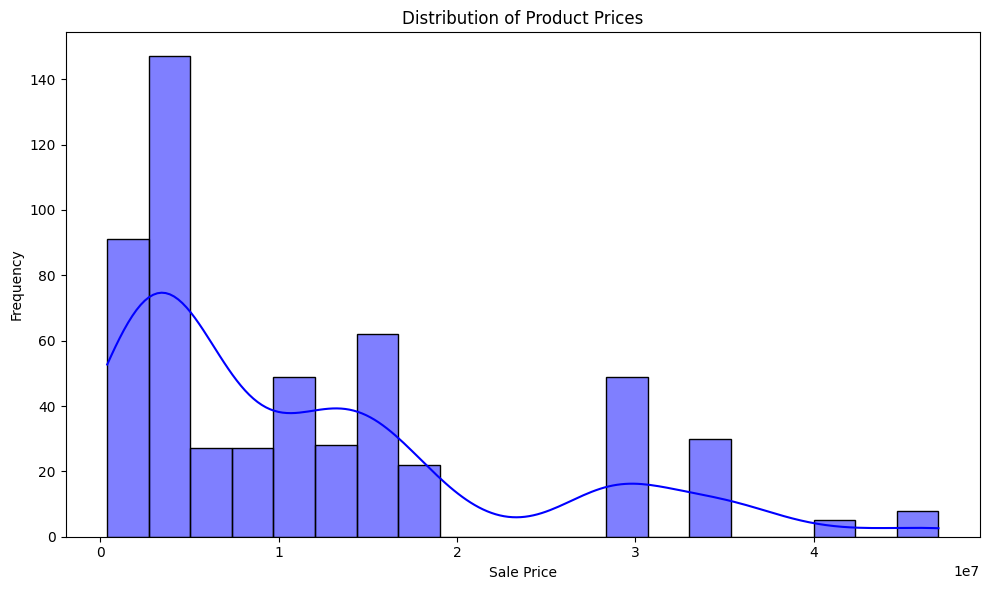

In [41]:
# Distribution of product prices
plt.figure(figsize=(10, 6))
sns.histplot(df['salePrice'], kde=True, bins=20, color='blue')
plt.title('Distribution of Product Prices')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

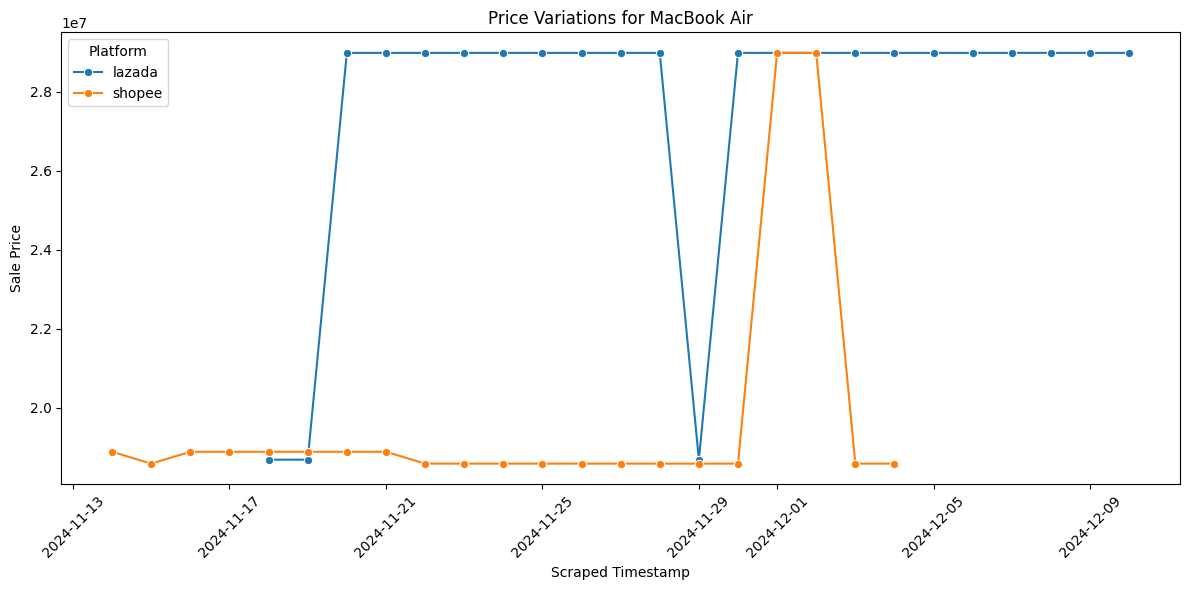

In [43]:
# Filter data for a specific item
item = "MacBook Air"
filtered_data = df[df['title'].str.contains(item, case=False, na=False)]

plt.figure(figsize=(12, 6))
sns.lineplot(data=filtered_data, x='scraped_timestamp', y='salePrice', hue='platform', marker='o')
plt.title(f'Price Variations for {item}')
plt.xlabel('Scraped Timestamp')
plt.ylabel('Sale Price')
plt.xticks(rotation=45)
plt.legend(title='Platform')
plt.tight_layout()
plt.show()

In [44]:
print("Summary Statistics:")
print(df[['salePrice']].describe())

Summary Statistics:
          salePrice
count  5.450000e+02
mean   1.168556e+07
std    1.114460e+07
min    3.920000e+05
25%    2.940000e+06
50%    7.900000e+06
75%    1.545000e+07
max    4.699900e+07


In [45]:
platform_group = df.groupby('platform').agg(
    avg_price=('salePrice', 'mean'),
    min_price=('salePrice', 'min'),
    max_price=('salePrice', 'max'),
    num_products=('itemId', 'nunique')
).reset_index()

print(platform_group)

  platform     avg_price   min_price   max_price  num_products
0   lazada  2.712426e+07  13290000.0  46999000.0             3
1   shopee  1.053116e+07    392000.0  34999000.0             6
2     tiki  9.096721e+06   1992000.0  28990000.0            14


C:\Users\Admin\AppData\Local\Temp\ipykernel_5292\2333363531.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_volatile, x='price_volatility', y='title', palette='coolwarm')


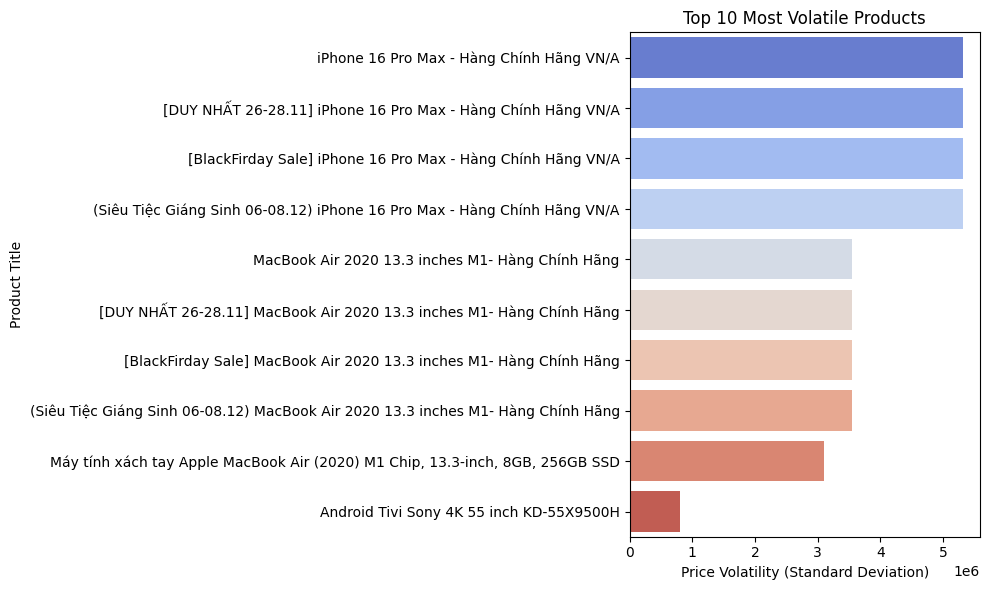

In [49]:
# Calculate price volatility (standard deviation) by product
volatility = df.groupby('itemId')['salePrice'].std().reset_index()
volatility = volatility.rename(columns={'salePrice': 'price_volatility'})

# Merge back to the main DataFrame
df = df.merge(volatility, on='itemId')

# Top 10 most volatile products
top_volatile = df[['title', 'price_volatility']].drop_duplicates().nlargest(10, 'price_volatility')

plt.figure(figsize=(10, 6))
sns.barplot(data=top_volatile, x='price_volatility', y='title', palette='coolwarm')
plt.title('Top 10 Most Volatile Products')
plt.xlabel('Price Volatility (Standard Deviation)')
plt.ylabel('Product Title')
plt.tight_layout()
plt.show()

In [53]:
!pip install -q prophet


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [54]:
from fbprophet import Prophet

# Prepare data for a specific product
item = "MacBook Air"
filtered_data = df[df['title'].str.contains(item, case=False, na=False)]
filtered_data = filtered_data[['scraped_timestamp', 'salePrice']].rename(
    columns={'scraped_timestamp': 'ds', 'salePrice': 'y'}
)

# Train Prophet model
model = Prophet()
model.fit(filtered_data)

# Forecast future prices
future = model.make_future_dataframe(periods=30)  # 30 days into the future
forecast = model.predict(future)

# Plot the forecast
model.plot(forecast)
plt.title(f'Price Forecast for {item}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

ModuleNotFoundError: No module named 'fbprophet'

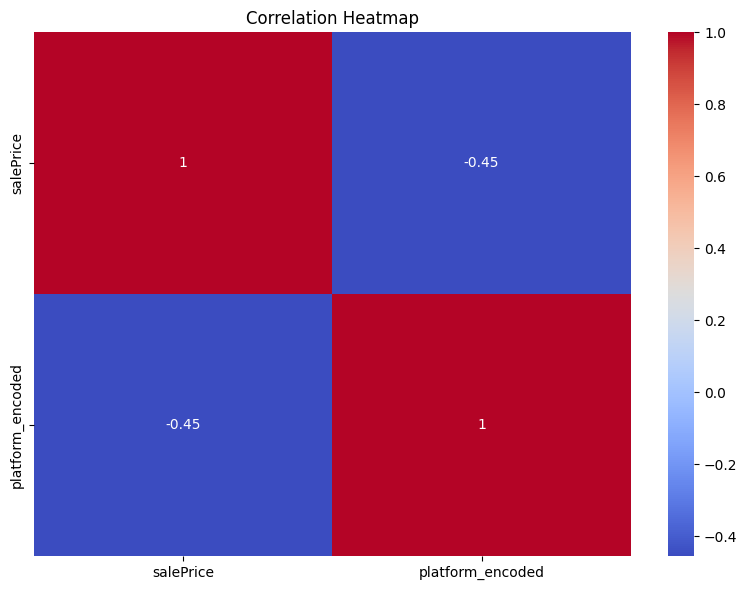

In [55]:
# Encode platform as numeric
df['platform_encoded'] = df['platform'].factorize()[0]

# Correlation heatmap
corr = df[['salePrice', 'platform_encoded']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

In [57]:
!pip install -q sklearn

  error: subprocess-exited-with-error
  
  Getting requirements to build wheel did not run successfully.
  exit code: 1
  
  [15 lines of output]
  The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
  rather than 'sklearn' for pip commands.
  
  Here is how to fix this error in the main use cases:
  - use 'pip install scikit-learn' rather than 'pip install sklearn'
  - replace 'sklearn' by 'scikit-learn' in your pip requirements files
    (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
  - if the 'sklearn' package is used by one of your dependencies,
    it would be great if you take some time to track which package uses
    'sklearn' instead of 'scikit-learn' and report it to their issue tracker
  - as a last resort, set the environment variable
    SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
  
  More information is available at
  https://github.com/scikit-learn/sklearn-pypi-package
  [end of output]
  
  note: This error originates f

In [58]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Pivot data for clustering
pivot_df = df.pivot_table(index='itemId', columns='scraped_timestamp', values='salePrice', aggfunc='mean').fillna(0)

# Normalize data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(pivot_df)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
pivot_df['cluster'] = kmeans.fit_predict(scaled_data)

# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pivot_df, x=pivot_df.columns[0], y=pivot_df.columns[1], hue='cluster', palette='viridis')
plt.title('Clustering Products by Price Trends')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

ModuleNotFoundError: No module named 'sklearn'

C:\Users\Admin\AppData\Local\Temp\ipykernel_5292\1439255548.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_discounts, x='price_change', y='title', palette='Reds')


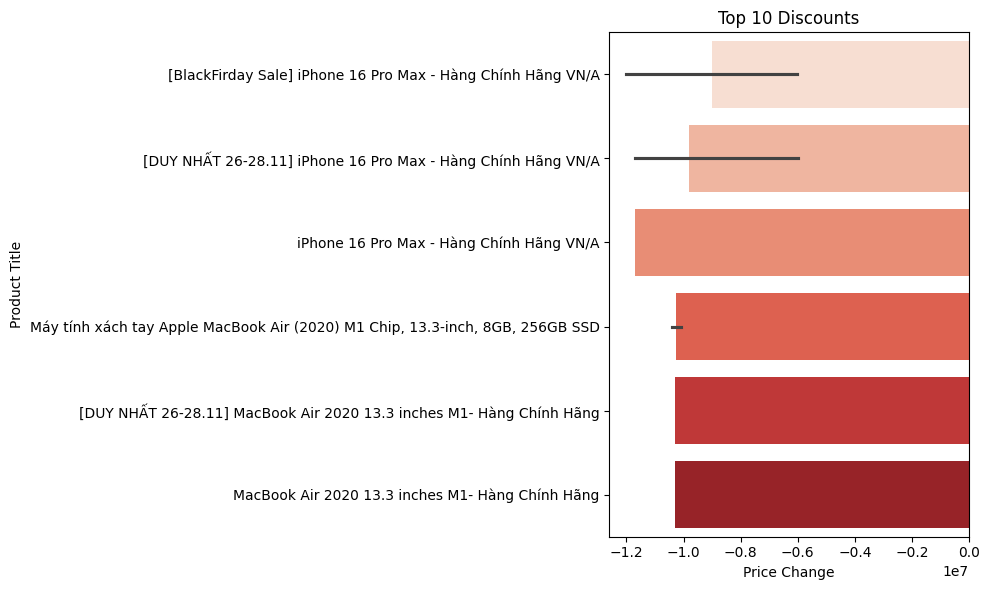

In [59]:
# Calculate price changes
df['price_change'] = df.groupby('itemId')['salePrice'].diff()

# Detect significant discounts
discounts = df[df['price_change'] < -500000]  # Threshold for discount detection

# Top 10 discounts
top_discounts = discounts.nsmallest(10, 'price_change')

plt.figure(figsize=(10, 6))
sns.barplot(data=top_discounts, x='price_change', y='title', palette='Reds')
plt.title('Top 10 Discounts')
plt.xlabel('Price Change')
plt.ylabel('Product Title')
plt.tight_layout()
plt.show()

In [62]:
!pip install -q textblob


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


C:\Users\Admin\AppData\Local\Temp\ipykernel_5292\366112629.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=platform_index, x='platform', y='performance_index', palette='Blues')


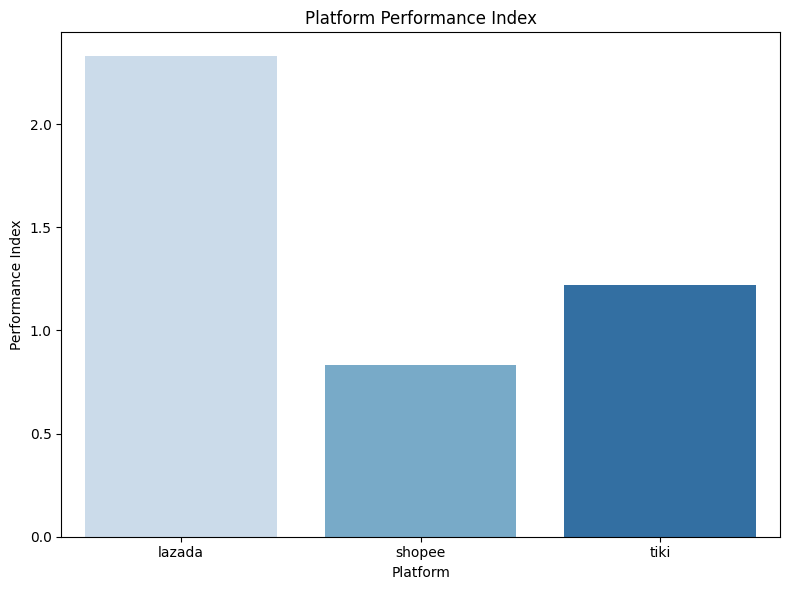

In [61]:
platform_index = df.groupby('platform').agg(
    avg_price=('salePrice', 'mean'),
    price_stability=('salePrice', lambda x: 1 / x.std() if x.std() != 0 else 0)
).reset_index()

# Normalize and create an index
platform_index['performance_index'] = (
    platform_index['avg_price'] * platform_index['price_stability']
)

plt.figure(figsize=(8, 6))
sns.barplot(data=platform_index, x='platform', y='performance_index', palette='Blues')
plt.title('Platform Performance Index')
plt.xlabel('Platform')
plt.ylabel('Performance Index')
plt.tight_layout()
plt.show()

In [2]:
import sqlite3
import pandas as pd

con = sqlite3.connect('e-com.sqlite')
cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())
con.close()

[('pdp',), ('review',), ('historical',), ('fact_sales',), ('sqlite_sequence',)]


In [24]:
import sqlite3
import pandas as pd

con = sqlite3.connect('e-com.sqlite')
cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
assert cursor.fetchall() == [('pdp',), ('review',), ('historical',)]

# List of tables
tables = ['pdp', 'review', 'historical']

# Check info for each table #
table_infos = {}
# for table in tables:
#     df = pd.read_sql_query(f"SELECT * FROM {table};", con)
#     table_infos[table] = df.info()


df = pd.read_sql_query(f"SELECT * FROM {tables[1]};", con)
print(df)
con.close()

     product_id platform  total_reviews  \
0    1040858590   lazada             65   
1    2730432618   lazada             65   
2    2792189799   lazada             65   
3    5873954476   shopee           2626   
4   24509035804   shopee             71   
5   27253416536   shopee            103   
6   27312277956   shopee             13   
7   27603632331   shopee              0   
8   29560903606   shopee           1094   
9      26140236     tiki              0   
10     57422387     tiki             16   
11    197665885     tiki            298   
12    248280562     tiki              0   
13    271362153     tiki              1   
14    271973414     tiki            256   
15    273258825     tiki             98   
16    273880674     tiki             11   
17    274037360     tiki             53   
18    274057334     tiki              1   
19    275078722     tiki              0   
20    275127044     tiki              0   
21    275716541     tiki              2   
22    27642

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     23 non-null     int64 
 1   platform       23 non-null     object
 2   total_reviews  23 non-null     int64 
 3   reviews        23 non-null     object
dtypes: int64(2), object(2)
memory usage: 868.0+ bytes


In [23]:
assert all(df['brand'].unique() == ['Apple', 'Samsung', 'CGO COMPUTER', 'Hải Nam Computers', 'Ecoking', 'Cidoo', 'MCC', 'Sony', 'Dell', 'Kindle', 'AMA', 'POCO', 'LG','HP', 'Realme', 'Nagakawa'])
df['brand'].value_counts(normalize=True)

brand
Apple                0.260870
Samsung              0.086957
LG                   0.086957
CGO COMPUTER         0.043478
Ecoking              0.043478
Cidoo                0.043478
MCC                  0.043478
Hải Nam Computers    0.043478
Sony                 0.043478
Dell                 0.043478
AMA                  0.043478
Kindle               0.043478
POCO                 0.043478
HP                   0.043478
Realme               0.043478
Nagakawa             0.043478
Name: proportion, dtype: float64